 # Food Classification Using Deep Neural Networks and Transfer Learning

# 1. Data Splitting 

Split the data into training, validation, and test sets. Justify your choice.

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


# Load Data

In [6]:
def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('falafel','apple_pie','donuts','french_fries','macarons','nachos','onion_rings','oysters','pizza', 'mussels')

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
    [transforms.Resize((224,224), interpolation=2), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.ImageFolder(root = 'train',
                                                 transform=transform)
 
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                              num_workers = 1, shuffle = True)

    
    val_set = torchvision.datasets.ImageFolder(root='val',
                                                 transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                              num_workers=1, shuffle = True)

    testset = torchvision.datasets.ImageFolder(root= 'test',
                                            transform=transform)
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, shuffle = True)

    return train_loader, classes#, val_loader, test_loader, classes

In [7]:
classes = ('falafel','apple_pie','donuts','french_fries','macarons','nachos','onion_rings','oysters','pizza', 'mussels')

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.Resize((224,224), interpolation=2), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.ImageFolder(root = 'train',
                                             transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 64,
                                          num_workers = 1, shuffle = True)
val_set = torchvision.datasets.ImageFolder(root='val',
                                                 transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64,
                                              num_workers=1, shuffle = True)

testset = torchvision.datasets.ImageFolder(root= 'test',
                                            transform=transform)
    
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                             num_workers=1, shuffle = True)

In [6]:
trainset.class_to_idx


{'apple_pie': 0,
 'donuts': 1,
 'falafel': 2,
 'french_fries': 3,
 'macarons': 4,
 'mussels': 5,
 'nachos': 6,
 'onion_rings': 7,
 'oysters': 8,
 'pizza': 9}

In [7]:
train_loader_iter = iter(train_loader)
imgs, labels = next(train_loader_iter)
print(imgs.shape)
print(labels)
print(labels.shape)

torch.Size([64, 3, 224, 224])
tensor([4, 3, 8, 5, 5, 3, 9, 5, 7, 5, 2, 6, 2, 2, 3, 0, 1, 4, 4, 9, 2, 8, 7, 2,
        4, 4, 0, 4, 9, 8, 5, 1, 2, 8, 8, 6, 9, 6, 8, 6, 9, 4, 6, 1, 0, 5, 7, 6,
        8, 7, 8, 2, 3, 1, 4, 4, 2, 5, 0, 9, 6, 7, 0, 4])
torch.Size([64])


# 2. Convolutional Network - Baseline Model 
Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional? What about other decisions like pooling layers, activation functions, number of channels / hidden units.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
 
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# 3. Training 
Train your network. Plot the training curve.

Make sure that you are checkpointing frequently!

In [14]:
import torch.nn as nn
import torch.nn.functional as F
# convolutional neural network, 
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 3, padding = 1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3, padding = 1)
        self.conv3 = nn.Conv2d(10, 15, 3, padding = 1)
        self.fc1 = nn.Linear(15 * 28 * 28 , 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 15 * 28 * 28)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [15]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [16]:
train_loader_iter = iter(train_loader)
imgs, labels = next(train_loader_iter)
print(imgs.shape)
print(labels)
print(labels.shape)

torch.Size([64, 3, 224, 224])
tensor([5, 9, 4, 4, 6, 0, 8, 3, 5, 4, 9, 4, 4, 9, 8, 7, 9, 6, 9, 6, 9, 3, 7, 4,
        2, 7, 9, 6, 4, 8, 0, 1, 5, 0, 8, 3, 5, 7, 8, 2, 2, 4, 4, 8, 0, 2, 8, 6,
        9, 9, 9, 5, 2, 4, 2, 9, 6, 8, 1, 3, 1, 9, 6, 2])
torch.Size([64])


# Training - Baseline Model

In [17]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        total_err += pred.ne(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss

In [18]:
def train(net, batch_size=1, learning_rate=0.0001, num_epochs=30):
    transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.ImageFolder(root='train',
                                                 transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          num_workers=1, shuffle = True)
    
    train_loader_iter = iter(train_loader)
    imgs, labels = next(train_loader_iter)
    
    
    torch.manual_seed(1000)

   
  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    
    iters, losses, train_acc, val_acc = [], [], [], []
    start_time = time.time()
    # training
    n=0
    for epoch in range(num_epochs):  # loop over the dataset multiple times 
      
        total_train_loss = 0.0
        total_train_err = 0.0

        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
                      
            optimizer.zero_grad()
            outputs = net(inputs)
           
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            iters.append(n)
           
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            total_train_err += pred.ne(labels.view_as(pred)).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
           
            losses.append(float(loss)/batch_size)  
            n += 1# compute *average* loss
        
        train_err[epoch] = float(total_train_err) / total_epoch
     
        train_loss[epoch] = float(total_train_loss) / (i+1)
        
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
    
        print(("Epoch {}: Train err: {}, Train loss: {}  |" +
               "Validation err: {} , Validation loss:{} ").format(
                   epoch + 1,
            
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]
                        ))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        
          

In [19]:
# Training Curve
import matplotlib.pyplot as plt
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """

    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    plt.plot(range(1,16), train_err, label="Train")
    plt.plot(range(1,16), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,16), train_loss, label="Train")
    plt.plot(range(1,16), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Hyperparameter Seach - Baseline Model

In [20]:
ne3 = LargeNet()

In [18]:
train(ne3, batch_size = 64, learning_rate=0.001, num_epochs = 15)

Epoch 1: Train err: 0.8148333333333333, Train loss: 2.158148763027597  |Validation err: 0.723 , Validation loss:2.009124256670475 
Epoch 2: Train err: 0.7078333333333333, Train loss: 1.9445663310111838  |Validation err: 0.7025 , Validation loss:1.9168030060827732 
Epoch 3: Train err: 0.6698333333333333, Train loss: 1.856111766176021  |Validation err: 0.6735 , Validation loss:1.9394507482647896 
Epoch 4: Train err: 0.628, Train loss: 1.7505208304587832  |Validation err: 0.641 , Validation loss:1.867951549589634 
Epoch 5: Train err: 0.5693333333333334, Train loss: 1.6187293821192803  |Validation err: 0.658 , Validation loss:1.9066818878054619 
Epoch 6: Train err: 0.5073333333333333, Train loss: 1.456289514582208  |Validation err: 0.642 , Validation loss:1.8620629645884037 
Epoch 7: Train err: 0.41933333333333334, Train loss: 1.2551947939903179  |Validation err: 0.659 , Validation loss:2.0057723075151443 
Epoch 8: Train err: 0.351, Train loss: 1.0611330454653882  |Validation err: 0.6685 ,

In [20]:
ne3 = LargeNet()
train(ne3, batch_size = 64, learning_rate=0.1, num_epochs = 15)

Epoch 1: Train err: 0.905, Train loss: 69.27644053164948  |Validation err: 0.9 , Validation loss:2.305116042494774 
Epoch 2: Train err: 0.8991666666666667, Train loss: 2.310235708317858  |Validation err: 0.9 , Validation loss:2.306180879473686 
Epoch 3: Train err: 0.9078333333333334, Train loss: 2.3106132263832904  |Validation err: 0.9 , Validation loss:2.3110063523054123 
Epoch 4: Train err: 0.9058333333333334, Train loss: 2.3119596395086734  |Validation err: 0.9 , Validation loss:2.3066415563225746 
Epoch 5: Train err: 0.8973333333333333, Train loss: 2.312528721829678  |Validation err: 0.9 , Validation loss:2.3107978478074074 
Epoch 6: Train err: 0.9033333333333333, Train loss: 2.3107845377414784  |Validation err: 0.9 , Validation loss:2.317298397421837 
Epoch 7: Train err: 0.9025, Train loss: 2.3116819300550095  |Validation err: 0.9 , Validation loss:2.311502568423748 
Epoch 8: Train err: 0.9026666666666666, Train loss: 2.313047170639038  |Validation err: 0.9 , Validation loss:2.305

In [17]:
ne3 = LargeNet()
train(ne3, batch_size = 32, learning_rate=0.001, num_epochs = 15)

Epoch 1: Train err: 0.9795918367346939, Train loss: 2.3734283447265625  |Validation err: 0.888 , Validation loss:2.3043167099120123 
Epoch 2: Train err: 0.9081632653061225, Train loss: 2.290855824947357  |Validation err: 0.8775 , Validation loss:2.302852191622295 
Epoch 3: Train err: 0.8061224489795918, Train loss: 2.2846043705940247  |Validation err: 0.901 , Validation loss:2.314066497106401 
Epoch 4: Train err: 0.8367346938775511, Train loss: 2.13023641705513  |Validation err: 0.907 , Validation loss:2.341324866764129 
Epoch 5: Train err: 0.7142857142857143, Train loss: 2.084831118583679  |Validation err: 0.8955 , Validation loss:2.4171635347699363 
Epoch 6: Train err: 0.6938775510204082, Train loss: 1.9880781471729279  |Validation err: 0.883 , Validation loss:2.561256310296437 
Epoch 7: Train err: 0.6836734693877551, Train loss: 1.9308159351348877  |Validation err: 0.9 , Validation loss:2.717611956217932 
Epoch 8: Train err: 0.5918367346938775, Train loss: 1.7282463312149048  |Valid

In [18]:
ne3 = LargeNet()
train(ne3, batch_size = 32, learning_rate=0.01, num_epochs = 15)

Epoch 1: Train err: 0.9693877551020408, Train loss: 3.077807307243347  |Validation err: 0.8865 , Validation loss:2.302529043621487 
Epoch 2: Train err: 0.8673469387755102, Train loss: 2.314727246761322  |Validation err: 0.885 , Validation loss:2.3035942410665844 
Epoch 3: Train err: 0.9081632653061225, Train loss: 2.3299266695976257  |Validation err: 0.872 , Validation loss:2.303005570457095 
Epoch 4: Train err: 0.8367346938775511, Train loss: 2.2420854568481445  |Validation err: 0.8975 , Validation loss:2.307703521516588 
Epoch 5: Train err: 0.8163265306122449, Train loss: 2.2963311076164246  |Validation err: 0.9065 , Validation loss:2.3334713776906333 
Epoch 6: Train err: 0.7244897959183674, Train loss: 2.034865379333496  |Validation err: 0.8985 , Validation loss:2.681612801930261 
Epoch 7: Train err: 0.6326530612244898, Train loss: 1.9049053490161896  |Validation err: 0.8875 , Validation loss:2.4091070341685463 
Epoch 8: Train err: 0.4387755102040816, Train loss: 1.718448281288147  

In [26]:
ne3 = LargeNet()
train(ne3, batch_size = 32, learning_rate=0.1, num_epochs = 15)

Epoch 1: Train err: 0.9693877551020408, Train loss: 550.2931333184242  |Validation err: 0.905 , Validation loss:2.7689754281725203 
Epoch 2: Train err: 0.9387755102040817, Train loss: 3.7385972142219543  |Validation err: 0.8995 , Validation loss:2.7221766918424577 
Epoch 3: Train err: 0.9489795918367347, Train loss: 2.364147186279297  |Validation err: 0.9005 , Validation loss:2.3685239383152554 
Epoch 4: Train err: 0.8979591836734694, Train loss: 2.294677972793579  |Validation err: 0.901 , Validation loss:2.4256414572397866 
Epoch 5: Train err: 0.8979591836734694, Train loss: 2.3738736510276794  |Validation err: 0.9 , Validation loss:2.4190590078868563 
Epoch 6: Train err: 0.8979591836734694, Train loss: 2.3401819467544556  |Validation err: 0.8995 , Validation loss:2.438799407747057 
Epoch 7: Train err: 0.8979591836734694, Train loss: 2.3592366576194763  |Validation err: 0.8985 , Validation loss:2.38091674683586 
Epoch 8: Train err: 0.8775510204081632, Train loss: 2.2866302728652954  |

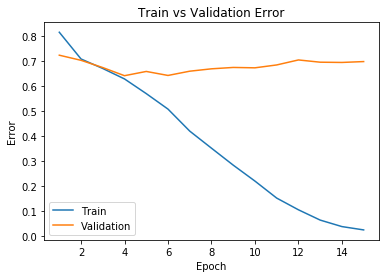

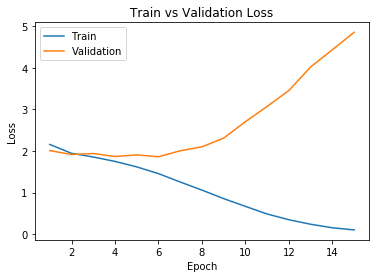

In [22]:
path = 'model_large_bs64_lr0.001_epoch14'
plot_training_curve(path)


# Test Classification Error

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.001, epoch=5)
state = torch.load(model_path)
net.load_state_dict(state)

evaluate(net, test_loader, nn.CrossEntropyLoss())


In [ ]:
The test classification error was about 0.37.

# Test Accuracy

In [292]:
def get_accuracy(model):
    data = testset
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=32):
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.001, epoch=5)
state = torch.load(model_path)
net.load_state_dict(state)




In [233]:
get_accuracy(net)

0.6222222222222222

# 5. Transfer Learning [16 pt]
For many image classification tasks, it is generally not a good idea to train a very large Deep Neural Network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data. One of the better option is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed â€œTransfer Learningâ€. In this assignment, we will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, Convolution layers extract various features from the images which get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal role in establishing Deep Neural Nets as a go-to tool for Image classification problems and we will use an imagenet pre-trained AlexNet model to extract features in this assignment.

# AlexNet

In [1]:
# Importing relevant Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import os
import torchvision
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.nn import functional as F
import copy
from torch.autograd import Variable


###############################################################################
# Feature Extraction using AlexNet pretrained model

class AlexNetFeatures(nn.Module):
    '''
    Class that loads AlexNet Feature Model ('Convolution layers') with imagenet trained weights
    
    input : image tensors with dimension Lx3x224x224
    
    output : feature tensor with dimension Lx256x6x6
    
    *L - Batch size
    
    '''
    
    def load_weights(self):
        an_builtin = torchvision.models.alexnet(pretrained=True) # Loads the pretrained model weights
        
        features_weight_i = [0, 3, 6, 8, 10]
        for i in features_weight_i:
            self.features[i].weight = an_builtin.features[i].weight
            self.features[i].bias = an_builtin.features[i].bias

    def __init__(self):
        super(AlexNetFeatures, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.load_weights() # Copies the weights to AlexNetFeatures model layers

    def forward(self, x):
        x = self.features(x)
        return x




In [2]:
myfeature_model = AlexNetFeatures()

In [3]:
for i, data in enumerate(train_loader, 0):

    inputs, labels = data
 
    features = myfeature_model(inputs)
for i, data in enumerate(val_loader, 0):

    inputs, labels = data
 
    features = myfeature_model(inputs)
for i, data in enumerate(test_loader, 0):

    inputs, labels = data
 
    features = myfeature_model(inputs)
   

NameError: name 'train_loader' is not defined

# Part (b) [5 pt]
Build a convolutional neural network model that takes as input these AlexNet features, and makes a prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation functions, number of channels / hidden units in each layer?

# Network For AlexNet

In [317]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "transferNet"
        self.conv1 = nn.Conv2d(256, 1, 3) 
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 9)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# Training With AlexNet

In [342]:
def evaluate2(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        
        features = myfeature_model(inputs)
        outputs = net(features)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        total_err += pred.ne(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss


In [345]:
def trainm(net, batch_size=64, learning_rate=0.0001, num_epochs=30):
  
    target_classes = ["A", "B", "C", "D",
               "E", "F", "G", "H", "I"]
    
    torch.manual_seed(1000)

    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    
    iters, losses, train_acc, val_acc = [], [], [], []
    start_time = time.time()
    # training
    n=0
    for epoch in range(num_epochs):  # loop over the dataset multiple times 
        total_train_loss = 0.0
        total_train_err = 0.0

        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            optimizer.zero_grad()
            features = myfeature_model(inputs)
            outputs = net(features)
            prob = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            iters.append(n)
           
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            total_train_err += pred.ne(labels.view_as(pred)).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
           
            losses.append(float(loss)/batch_size)  
            n += 1# compute *average* loss
        
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate2(net, val_loader, criterion)
        
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        
          

# Hyperparameter Search With AlexNet

In [348]:
net = Net()
trainm(net, batch_size=1, learning_rate=0.0001, num_epochs=20)

Epoch 1: Train err: 0.8595113438045375, Train loss: 2.191327426550068 |Validation err: 0.7489711934156379, Validation loss: 2.1361649968496565
Epoch 2: Train err: 0.7556719022687609, Train loss: 2.1192364577223493 |Validation err: 0.7325102880658436, Validation loss: 2.061200148774763
Epoch 3: Train err: 0.7260034904013961, Train loss: 2.0557315695972345 |Validation err: 0.6995884773662552, Validation loss: 2.004276502770161
Epoch 4: Train err: 0.6858638743455497, Train loss: 1.9838839731915459 |Validation err: 0.6255144032921811, Validation loss: 1.9033872144212447
Epoch 5: Train err: 0.6431064572425829, Train loss: 1.9034680759511484 |Validation err: 0.5679012345679012, Validation loss: 1.8201030124852686
Epoch 6: Train err: 0.6212914485165794, Train loss: 1.833899358388225 |Validation err: 0.5390946502057613, Validation loss: 1.734129064858205
Epoch 7: Train err: 0.5916230366492147, Train loss: 1.745175765967078 |Validation err: 0.5390946502057613, Validation loss: 1.593888433381853

# Part (d) [2 pt]
Report the test accuracy of your best model. How does the test accuracy compare to part 4(d)?

In [352]:
def get_accuracy(model):
    data = testset
    total = 0
    correct =0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=32):
        features = myfeature_model(imgs)
        output = net(features) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [355]:
get_accuracy(net)

0.6666666666666666